In [1]:
import numpy as np
import cPickle as pickle
import gym
import matplotlib.pyplot as plt

H = 10
learning_rate = 2e-3
gamma = 0.99
decay_rate = 0.99
score_queue_size = 100
resume = False
D = 3

In [2]:
if resume:  model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D)
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.iteritems() }
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.iteritems() }


In [3]:
def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x))

In [4]:
def prepro(I):
    return I[1:]

In [5]:
def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
        
    return discounted_r

In [6]:
def policy_forward(x):
    h = np.dot(model['W1'], x)
    h = sigmoid(h)
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h

In [7]:
def policy_backward(eph, epdlogp, epx):
    global grad_buffer
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    eph_dot = eph*(1-eph)
    dW1 = dh * eph_dot
    dW1 = np.dot(dW1.T, epx)
        
    for k in model: grad_buffer[k] += {'W1':dW1, 'W2':dW2}[k]

In [8]:
env = gym.make('CartPole-v0')
#env.monitor.start('CartPole', force=True)
observation = env.reset()
reward_sum, episode_num = 0,0
xs,hs,dlogps,drs = [],[],[],[]
score_queue = []
rList = []

[2017-07-25 14:02:42,958] Making new env: CartPole-v0


In [9]:
while True:
    
    x = prepro(observation)
    
    act_prob, h = policy_forward(x)
    
    if np.mean(score_queue) > 180:
        action = 1 if 0.5 < act_prob else 0
    else:
        action = 1 if np.random.uniform() < act_prob else 0

    xs.append(x)
    hs.append(h)
    y = action
    dlogps.append(y - act_prob)
    
    observation, reward, done, info = env.step(action)
    reward_sum += reward
    
    drs.append(reward)
    
    if done:
        episode_num += 1
        
        if episode_num > score_queue_size:
            score_queue.append(reward_sum)
            score_queue.pop(0)
        else:
            score_queue.append(reward_sum)
        
        print "episode : " + str(episode_num) + ", reward : " + str(reward_sum) + ", reward_mean : " + str(np.mean(score_queue))
        rList.append(reward_sum)
        if np.mean(score_queue) >= 200:
            print "CartPole solved!!!!!"
            break
        
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[]
        
        discounted_epr = discount_rewards(epr)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)
        
        epdlogp *= discounted_epr
        
        policy_backward(eph,epdlogp,epx)
        for k,v in model.iteritems():
            g = grad_buffer[k] 
            rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate)*g**2
            model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
            grad_buffer[k] = np.zeros_like(v)
        
        if episode_num % 1000 == 0: pickle.dump(model, open('Cart.p', 'wb'))
        
        reward_sum = 0
        observation = env.reset()
        

/home/howoongjun/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/howoongjun/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode : 1, reward : 29.0, reward_mean : 29.0
episode : 2, reward : 13.0, reward_mean : 21.0
episode : 3, reward : 14.0, reward_mean : 18.6666666667
episode : 4, reward : 20.0, reward_mean : 19.0
episode : 5, reward : 17.0, reward_mean : 18.6
episode : 6, reward : 20.0, reward_mean : 18.8333333333
episode : 7, reward : 18.0, reward_mean : 18.7142857143
episode : 8, reward : 26.0, reward_mean : 19.625
episode : 9, reward : 16.0, reward_mean : 19.2222222222
episode : 10, reward : 21.0, reward_mean : 19.4
episode : 11, reward : 18.0, reward_mean : 19.2727272727
episode : 12, reward : 27.0, reward_mean : 19.9166666667
episode : 13, reward : 10.0, reward_mean : 19.1538461538
episode : 14, reward : 25.0, reward_mean : 19.5714285714
episode : 15, reward : 12.0, reward_mean : 19.0666666667
episode : 16, reward : 37.0, reward_mean : 20.1875
episode : 17, reward : 24.0, reward_mean : 20.4117647059
episode : 18, reward : 52.0, reward_mean : 22.1666666667
episode : 19, reward : 58.0, reward_mean 

episode : 164, reward : 62.0, reward_mean : 26.89
episode : 165, reward : 9.0, reward_mean : 26.82
episode : 166, reward : 21.0, reward_mean : 26.84
episode : 167, reward : 16.0, reward_mean : 26.8
episode : 168, reward : 17.0, reward_mean : 26.63
episode : 169, reward : 58.0, reward_mean : 26.92
episode : 170, reward : 20.0, reward_mean : 26.73
episode : 171, reward : 23.0, reward_mean : 26.65
episode : 172, reward : 19.0, reward_mean : 26.62
episode : 173, reward : 14.0, reward_mean : 26.51
episode : 174, reward : 52.0, reward_mean : 26.37
episode : 175, reward : 19.0, reward_mean : 26.4
episode : 176, reward : 15.0, reward_mean : 26.4
episode : 177, reward : 41.0, reward_mean : 26.62
episode : 178, reward : 33.0, reward_mean : 26.7
episode : 179, reward : 36.0, reward_mean : 26.86
episode : 180, reward : 28.0, reward_mean : 26.43
episode : 181, reward : 15.0, reward_mean : 26.4
episode : 182, reward : 16.0, reward_mean : 26.43
episode : 183, reward : 17.0, reward_mean : 26.3
episode

episode : 444, reward : 104.0, reward_mean : 32.66
episode : 445, reward : 64.0, reward_mean : 33.09
episode : 446, reward : 53.0, reward_mean : 33.35
episode : 447, reward : 12.0, reward_mean : 33.34
episode : 448, reward : 13.0, reward_mean : 33.17
episode : 449, reward : 18.0, reward_mean : 33.2
episode : 450, reward : 14.0, reward_mean : 33.11
episode : 451, reward : 42.0, reward_mean : 33.31
episode : 452, reward : 81.0, reward_mean : 34.0
episode : 453, reward : 82.0, reward_mean : 34.44
episode : 454, reward : 82.0, reward_mean : 34.86
episode : 455, reward : 19.0, reward_mean : 34.35
episode : 456, reward : 22.0, reward_mean : 34.39
episode : 457, reward : 61.0, reward_mean : 34.77
episode : 458, reward : 43.0, reward_mean : 34.83
episode : 459, reward : 16.0, reward_mean : 34.67
episode : 460, reward : 21.0, reward_mean : 34.65
episode : 461, reward : 71.0, reward_mean : 35.14
episode : 462, reward : 42.0, reward_mean : 35.37
episode : 463, reward : 24.0, reward_mean : 35.27
e

episode : 676, reward : 30.0, reward_mean : 38.2
episode : 677, reward : 37.0, reward_mean : 38.08
episode : 678, reward : 41.0, reward_mean : 38.22
episode : 679, reward : 39.0, reward_mean : 38.24
episode : 680, reward : 31.0, reward_mean : 38.07
episode : 681, reward : 59.0, reward_mean : 38.13
episode : 682, reward : 51.0, reward_mean : 38.48
episode : 683, reward : 23.0, reward_mean : 37.94
episode : 684, reward : 49.0, reward_mean : 38.25
episode : 685, reward : 83.0, reward_mean : 38.91
episode : 686, reward : 66.0, reward_mean : 39.26
episode : 687, reward : 21.0, reward_mean : 38.12
episode : 688, reward : 33.0, reward_mean : 37.86
episode : 689, reward : 16.0, reward_mean : 37.72
episode : 690, reward : 23.0, reward_mean : 37.82
episode : 691, reward : 71.0, reward_mean : 38.06
episode : 692, reward : 38.0, reward_mean : 37.93
episode : 693, reward : 21.0, reward_mean : 37.97
episode : 694, reward : 52.0, reward_mean : 38.18
episode : 695, reward : 31.0, reward_mean : 38.17
e

episode : 847, reward : 60.0, reward_mean : 46.27
episode : 848, reward : 34.0, reward_mean : 46.3
episode : 849, reward : 39.0, reward_mean : 46.35
episode : 850, reward : 65.0, reward_mean : 46.87
episode : 851, reward : 42.0, reward_mean : 46.79
episode : 852, reward : 89.0, reward_mean : 47.55
episode : 853, reward : 60.0, reward_mean : 47.66
episode : 854, reward : 20.0, reward_mean : 47.33
episode : 855, reward : 30.0, reward_mean : 47.51
episode : 856, reward : 16.0, reward_mean : 47.45
episode : 857, reward : 55.0, reward_mean : 47.68
episode : 858, reward : 22.0, reward_mean : 47.37
episode : 859, reward : 97.0, reward_mean : 48.08
episode : 860, reward : 24.0, reward_mean : 47.94
episode : 861, reward : 25.0, reward_mean : 47.77
episode : 862, reward : 38.0, reward_mean : 47.89
episode : 863, reward : 65.0, reward_mean : 48.01
episode : 864, reward : 28.0, reward_mean : 47.35
episode : 865, reward : 29.0, reward_mean : 47.3
episode : 866, reward : 27.0, reward_mean : 47.3
epi

episode : 1016, reward : 58.0, reward_mean : 56.03
episode : 1017, reward : 61.0, reward_mean : 56.38
episode : 1018, reward : 49.0, reward_mean : 55.56
episode : 1019, reward : 65.0, reward_mean : 55.53
episode : 1020, reward : 50.0, reward_mean : 55.57
episode : 1021, reward : 30.0, reward_mean : 55.23
episode : 1022, reward : 51.0, reward_mean : 55.38
episode : 1023, reward : 54.0, reward_mean : 55.33
episode : 1024, reward : 72.0, reward_mean : 55.89
episode : 1025, reward : 19.0, reward_mean : 55.43
episode : 1026, reward : 30.0, reward_mean : 55.22
episode : 1027, reward : 90.0, reward_mean : 55.81
episode : 1028, reward : 61.0, reward_mean : 56.09
episode : 1029, reward : 72.0, reward_mean : 56.33
episode : 1030, reward : 25.0, reward_mean : 56.16
episode : 1031, reward : 56.0, reward_mean : 56.25
episode : 1032, reward : 68.0, reward_mean : 56.34
episode : 1033, reward : 74.0, reward_mean : 56.83
episode : 1034, reward : 80.0, reward_mean : 57.46
episode : 1035, reward : 22.0, 

episode : 1214, reward : 79.0, reward_mean : 78.88
episode : 1215, reward : 44.0, reward_mean : 78.47
episode : 1216, reward : 73.0, reward_mean : 78.84
episode : 1217, reward : 200.0, reward_mean : 80.44
episode : 1218, reward : 64.0, reward_mean : 80.54
episode : 1219, reward : 105.0, reward_mean : 80.1
episode : 1220, reward : 46.0, reward_mean : 79.94
episode : 1221, reward : 200.0, reward_mean : 81.69
episode : 1222, reward : 115.0, reward_mean : 82.49
episode : 1223, reward : 55.0, reward_mean : 82.68
episode : 1224, reward : 113.0, reward_mean : 83.12
episode : 1225, reward : 80.0, reward_mean : 82.8
episode : 1226, reward : 47.0, reward_mean : 82.85
episode : 1227, reward : 148.0, reward_mean : 83.86
episode : 1228, reward : 49.0, reward_mean : 82.96
episode : 1229, reward : 200.0, reward_mean : 83.8
episode : 1230, reward : 54.0, reward_mean : 83.71
episode : 1231, reward : 119.0, reward_mean : 84.55
episode : 1232, reward : 29.0, reward_mean : 84.53
episode : 1233, reward : 1

episode : 1395, reward : 190.0, reward_mean : 118.12
episode : 1396, reward : 123.0, reward_mean : 118.16
episode : 1397, reward : 200.0, reward_mean : 118.16
episode : 1398, reward : 100.0, reward_mean : 118.78
episode : 1399, reward : 200.0, reward_mean : 118.83
episode : 1400, reward : 99.0, reward_mean : 118.5
episode : 1401, reward : 101.0, reward_mean : 119.02
episode : 1402, reward : 118.0, reward_mean : 118.78
episode : 1403, reward : 97.0, reward_mean : 119.6
episode : 1404, reward : 29.0, reward_mean : 118.62
episode : 1405, reward : 200.0, reward_mean : 119.1
episode : 1406, reward : 110.0, reward_mean : 119.54
episode : 1407, reward : 78.0, reward_mean : 120.07
episode : 1408, reward : 130.0, reward_mean : 119.37
episode : 1409, reward : 185.0, reward_mean : 120.09
episode : 1410, reward : 64.0, reward_mean : 118.73
episode : 1411, reward : 151.0, reward_mean : 118.24
episode : 1412, reward : 200.0, reward_mean : 119.12
episode : 1413, reward : 78.0, reward_mean : 118.86
ep

episode : 1574, reward : 200.0, reward_mean : 137.41
episode : 1575, reward : 173.0, reward_mean : 138.96
episode : 1576, reward : 135.0, reward_mean : 140.07
episode : 1577, reward : 172.0, reward_mean : 140.9
episode : 1578, reward : 111.0, reward_mean : 140.13
episode : 1579, reward : 186.0, reward_mean : 141.49
episode : 1580, reward : 183.0, reward_mean : 142.13
episode : 1581, reward : 124.0, reward_mean : 141.43
episode : 1582, reward : 75.0, reward_mean : 140.54
episode : 1583, reward : 143.0, reward_mean : 140.97
episode : 1584, reward : 200.0, reward_mean : 141.99
episode : 1585, reward : 137.0, reward_mean : 141.36
episode : 1586, reward : 53.0, reward_mean : 140.08
episode : 1587, reward : 115.0, reward_mean : 140.47
episode : 1588, reward : 200.0, reward_mean : 142.04
episode : 1589, reward : 165.0, reward_mean : 142.62
episode : 1590, reward : 171.0, reward_mean : 142.84
episode : 1591, reward : 157.0, reward_mean : 143.36
episode : 1592, reward : 139.0, reward_mean : 143

episode : 1735, reward : 200.0, reward_mean : 163.25
episode : 1736, reward : 200.0, reward_mean : 163.92
episode : 1737, reward : 150.0, reward_mean : 163.51
episode : 1738, reward : 200.0, reward_mean : 164.0
episode : 1739, reward : 200.0, reward_mean : 164.88
episode : 1740, reward : 200.0, reward_mean : 164.88
episode : 1741, reward : 200.0, reward_mean : 166.48
episode : 1742, reward : 104.0, reward_mean : 166.47
episode : 1743, reward : 32.0, reward_mean : 165.5
episode : 1744, reward : 41.0, reward_mean : 163.91
episode : 1745, reward : 200.0, reward_mean : 163.91
episode : 1746, reward : 200.0, reward_mean : 163.91
episode : 1747, reward : 200.0, reward_mean : 163.91
episode : 1748, reward : 200.0, reward_mean : 163.91
episode : 1749, reward : 155.0, reward_mean : 163.58
episode : 1750, reward : 51.0, reward_mean : 163.25
episode : 1751, reward : 200.0, reward_mean : 163.25
episode : 1752, reward : 134.0, reward_mean : 162.59
episode : 1753, reward : 190.0, reward_mean : 163.4

episode : 1918, reward : 87.0, reward_mean : 162.24
episode : 1919, reward : 130.0, reward_mean : 162.44
episode : 1920, reward : 165.0, reward_mean : 163.83
episode : 1921, reward : 200.0, reward_mean : 163.83
episode : 1922, reward : 200.0, reward_mean : 164.14
episode : 1923, reward : 200.0, reward_mean : 164.14
episode : 1924, reward : 102.0, reward_mean : 163.57
episode : 1925, reward : 200.0, reward_mean : 163.57
episode : 1926, reward : 200.0, reward_mean : 163.57
episode : 1927, reward : 193.0, reward_mean : 163.5
episode : 1928, reward : 200.0, reward_mean : 163.5
episode : 1929, reward : 170.0, reward_mean : 163.94
episode : 1930, reward : 200.0, reward_mean : 164.56
episode : 1931, reward : 200.0, reward_mean : 164.91
episode : 1932, reward : 200.0, reward_mean : 164.91
episode : 1933, reward : 162.0, reward_mean : 165.25
episode : 1934, reward : 200.0, reward_mean : 165.85
episode : 1935, reward : 200.0, reward_mean : 165.85
episode : 1936, reward : 200.0, reward_mean : 166

episode : 2082, reward : 200.0, reward_mean : 179.77
episode : 2083, reward : 200.0, reward_mean : 179.77
episode : 2084, reward : 127.0, reward_mean : 179.77
episode : 2085, reward : 200.0, reward_mean : 179.77
episode : 2086, reward : 147.0, reward_mean : 179.24
episode : 2087, reward : 200.0, reward_mean : 179.24
episode : 2088, reward : 200.0, reward_mean : 179.82
episode : 2089, reward : 200.0, reward_mean : 179.82
episode : 2090, reward : 200.0, reward_mean : 179.82
episode : 2091, reward : 157.0, reward_mean : 179.39
episode : 2092, reward : 200.0, reward_mean : 179.39
episode : 2093, reward : 182.0, reward_mean : 179.21
episode : 2094, reward : 126.0, reward_mean : 178.47
episode : 2095, reward : 200.0, reward_mean : 178.47
episode : 2096, reward : 200.0, reward_mean : 178.47
episode : 2097, reward : 154.0, reward_mean : 178.01
episode : 2098, reward : 200.0, reward_mean : 178.01
episode : 2099, reward : 157.0, reward_mean : 177.58
episode : 2100, reward : 200.0, reward_mean : 

episode : 2245, reward : 200.0, reward_mean : 183.4
episode : 2246, reward : 200.0, reward_mean : 183.78
episode : 2247, reward : 200.0, reward_mean : 184.76
episode : 2248, reward : 200.0, reward_mean : 184.84
episode : 2249, reward : 200.0, reward_mean : 185.32
episode : 2250, reward : 200.0, reward_mean : 185.32
episode : 2251, reward : 200.0, reward_mean : 185.32
episode : 2252, reward : 200.0, reward_mean : 185.32
episode : 2253, reward : 200.0, reward_mean : 185.32
episode : 2254, reward : 200.0, reward_mean : 185.32
episode : 2255, reward : 200.0, reward_mean : 185.88
episode : 2256, reward : 200.0, reward_mean : 185.88
episode : 2257, reward : 200.0, reward_mean : 186.46
episode : 2258, reward : 200.0, reward_mean : 187.82
episode : 2259, reward : 200.0, reward_mean : 187.82
episode : 2260, reward : 200.0, reward_mean : 187.82
episode : 2261, reward : 200.0, reward_mean : 188.26
episode : 2262, reward : 200.0, reward_mean : 188.26
episode : 2263, reward : 200.0, reward_mean : 1

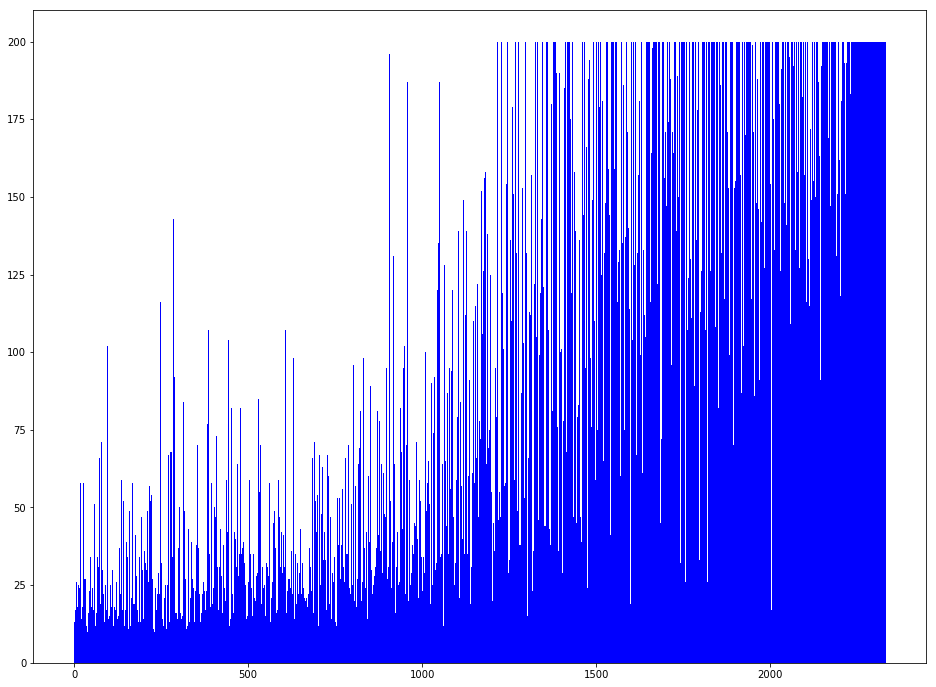

In [19]:
plt.bar(range(len(rList)), rList, color = "blue", width = 1)
figure = plt.gcf()
figure.set_size_inches(16, 12)
plt.show()